**Dataset Management**


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rashidthihan/plant-doc-dataset-augmented")

print("Path to dataset files:", path)

100%|██████████| 4.36G/4.36G [01:01<00:00, 76.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rashidthihan/plant-doc-dataset-augmented/versions/1


**Imports**

In [ ]:
from pathlib import Path
import os, random, time, json, warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import ImageFile

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

**Preprocess Data**

In [ ]:

BASE_DATA_DIR = Path("/kaggle/input/plant-doc-dataset-augmented/augmented_plantdoc")

CONFIG = {
    # Data parameters
    "seed": 42,
    "img_size": 224,
    "batch_size": 32,

    # Training parameters
    "epochs": 20,
    "initial_lr": 5e-4,
    "finetune_lr": 1e-4,
    "weight_decay": 5e-4,

    # Model architecture
    "dropout": 0.2,
    "pretrained": True,

    # Regularization
    "label_smoothing": 0.1,   # Prevents overconfident predictions

    # Training phases
    "phase1_epochs": 5,       # Train classifier only
    "phase2_epochs": 15,      # Fine-tune last layers

    # Paths
    "save_dir": Path("/kaggle/working/plant_disease_model_exports"),
}

CONFIG["save_dir"].mkdir(parents=True, exist_ok=True)

# print(" Hyperparameters:")
# for key, value in CONFIG.items():
#     print(f"   {key}: {value}")

**Utility Functions**

In [ ]:
def seed_everything(seed=42):
    """Set seeds for reproducibility across all libraries."""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(CONFIG["seed"])
print(f" TensorFlow version: {tf.__version__}")
print(f" Random seed set to: {CONFIG['seed']}")

 TensorFlow version: 2.19.0
 Random seed set to: 42


In [ ]:
def verify_dataset_structure(base_dir, expected_classes, expected_splits):

    issues = []
    stats = {"train": {}, "val": {}, "test": {}}

    for split in expected_splits:
        split_dir = base_dir / split
        if not split_dir.exists():
            issues.append(f"Missing split directory: {split}")
            continue

        for class_name in expected_classes:
            class_dir = split_dir / class_name
            if not class_dir.exists():
                issues.append(f"Missing class '{class_name}' in {split}/")
                stats[split][class_name] = 0
                continue

            # Count valid images
            valid_images = [f for f in class_dir.iterdir()
                          if f.suffix.lower() in ['.png', '.jpg', '.jpeg', '.bmp']]
            stats[split][class_name] = len(valid_images)

    return stats, issues

**Data Preparation & Verification**

In [ ]:
print("\n" + "="*60)
print(" LOADING AUGMENTED PLANT DISEASE DATASET")
print("="*60)

# Expected directory structure
train_dir = BASE_DATA_DIR / "train"
val_dir = BASE_DATA_DIR / "val"
test_dir = BASE_DATA_DIR / "test"

# Verify dataset structure
print("\n Verifying dataset structure...")
stats, issues = verify_dataset_structure(
    BASE_DATA_DIR,
    DATASET_CONFIG["classes"],
    ["train", "val", "test"]
)

if issues:
    print("\n  Dataset structure issues found:")
    for issue in issues[:10]:  # Show first 10 issues
        print(f"   - {issue}")
    if len(issues) > 10:
        print(f"   ... and {len(issues)-10} more issues")
else:
    print("   Dataset structure verified")

# Calculate actual totals
actual_train = sum(stats["train"].values())
actual_val = sum(stats["val"].values())
actual_test = sum(stats["test"].values())

print(f"\n Dataset Statistics:")
print(f"   Classes: {len(DATASET_CONFIG['classes'])}")
print(f"   Train: {actual_train:,} images (expected: {DATASET_CONFIG['total_train']:,})")
print(f"   Val: {actual_val:,} images (expected: {DATASET_CONFIG['total_val']:,})")
print(f"   Test: {actual_test:,} images (expected: {DATASET_CONFIG['total_test']:,})")
print(f"   Total: {actual_train + actual_val + actual_test:,} images")


 LOADING AUGMENTED PLANT DISEASE DATASET

 Verifying dataset structure...

  Dataset structure issues found:
   - Missing split directory: train
   - Missing split directory: val
   - Missing split directory: test

 Dataset Statistics:
   Classes: 27
   Train: 0 images (expected: 7,560)
   Val: 0 images (expected: 1,620)
   Test: 0 images (expected: 1,620)
   Total: 0 images


In [ ]:
# Display class distribution
print(f"  Class Distribution (samples per class):")
print(f"   {'Class Name':<35} {'Train':>6} {'Val':>6} {'Test':>6}")
print(f"   {'-'*35} {'-'*6} {'-'*6} {'-'*6}")
for class_name in DATASET_CONFIG["classes"]:
    train_count = stats["train"].get(class_name, 0)
    val_count = stats["val"].get(class_name, 0)
    test_count = stats["test"].get(class_name, 0)
    print(f"   {class_name:<35} {train_count:>6} {val_count:>6} {test_count:>6}")

  Class Distribution (samples per class):
   Class Name                           Train    Val   Test
   ----------------------------------- ------ ------ ------
   Corn leaf blight                         0      0      0
   Tomato leaf                              0      0      0
   Tomato leaf mosaic virus                 0      0      0
   Squash Powdery mildew leaf               0      0      0
   Potato leaf late blight                  0      0      0
   Soyabean leaf                            0      0      0
   Peach leaf                               0      0      0
   Tomato leaf late blight                  0      0      0
   Apple leaf                               0      0      0
   Tomato mold leaf                         0      0      0
   Corn Gray leaf spot                      0      0      0
   Tomato leaf yellow virus                 0      0      0
   Strawberry leaf                          0      0      0
   Cherry leaf                              0      0      

**Create Data Generators**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rashidthihan/plant-doc-dataset-augmented")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'plant-doc-dataset-augmented' dataset.
Path to dataset files: /kaggle/input/plant-doc-dataset-augmented


In [ ]:
IMG_SIZE = CONFIG["img_size"]

# No augmentation - dataset is already augmented
# preprocessing (normalization)
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Create data generators
print(" Creating data generators...")

train_generator = datagen.flow_from_directory(
    str(train_dir),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=CONFIG["batch_size"],
    class_mode='categorical',
    shuffle=True,
    seed=CONFIG["seed"]
)

valid_generator = datagen.flow_from_directory(
    str(val_dir),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=CONFIG["batch_size"],
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    str(test_dir),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=CONFIG["batch_size"],
    class_mode='categorical',
    shuffle=False
)

num_classes = DATASET_CONFIG["num_classes"]
class_names = list(train_generator.class_indices.keys())

print(f"\n Data generators created successfully")
print(f"   Train batches: {len(train_generator)}")
print(f"   Val batches: {len(valid_generator)}")
print(f"   Test batches: {len(test_generator)}")

 Creating data generators...
Found 7559 images belonging to 27 classes.
Found 1620 images belonging to 27 classes.
Found 1620 images belonging to 27 classes.

 Data generators created successfully
   Train batches: 237
   Val batches: 51
   Test batches: 51


**Model Architecture**

In [ ]:
def create_model(num_classes, dropout=0.2, l2_reg=5e-4):

    # Load pretrained MobileNetV2 (without top classifier)
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )

    # Freeze base model initially
    base_model.trainable = False

    # Build custom classifier for 27 plant disease classes with regularization
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)

    # Add BatchNormalization for stability
    x = layers.BatchNormalization()(x)

    # First dropout layer
    x = layers.Dropout(dropout)(x)

    # Dense layer with L2 regularization
    x = layers.Dense(
        256,
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(l2_reg)
    )(x)

    # Second BatchNormalization
    x = layers.BatchNormalization()(x)

    # Second dropout layer
    x = layers.Dropout(dropout)(x)

    # Output layer with L2 regularization
    outputs = layers.Dense(
        num_classes,
        activation='softmax',
        kernel_regularizer=keras.regularizers.l2(l2_reg)
    )(x)

    model = keras.Model(inputs, outputs, name='PlantDiseaseClassifier')
    return model, base_model

In [ ]:
print("\n" + "="*60)
print(" BUILDING MODEL")
print("="*60)

model, base_model = create_model(
    num_classes=num_classes,
    dropout=CONFIG["dropout"],
    l2_reg=CONFIG["weight_decay"]
)

total_params = model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"   Architecture: MobileNetV2 + Custom Classifier")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Output classes: {num_classes} (Plant Disease Classes)")

# Display model summary
model.summary()




 BUILDING MODEL
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
   Architecture: MobileNetV2 + Custom Classifier
   Total parameters: 2,599,003
   Trainable parameters: 337,947
   Output classes: 27 (Plant Disease Classes)


Model: "PlantDiseaseClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 27)             │         6,939 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,599,003 (9.91 MB)

 Trainable params: 337,947 (1.29 MB)

 Non-trainable params: 2,261,056 (8.63 MB)


  Anti-Overfitting Mechanisms:
   ✓ Dropout: 0.2 (applied twice)
   ✓ L2 Regularization: 0.0005
   ✓ Label Smoothing: 0.1
   ✓ Batch Normalization: 2 layers
   ✓ Early Stopping: patience=5
   ✓ Learning Rate Scheduling: ReduceLROnPlateau
   ✓ Two-Phase Training: Freeze → Fine-tune


**Training Setup**

In [ ]:
train_labels = train_generator.classes
class_weights_np = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_np)}
print(f"  Class Weights: {class_weights_np.min():.3f} - {class_weights_np.max():.3f}")
print(f"   (Balanced dataset - weights should be close to 1.0)")

  Class Weights: 1.000 - 1.003
   (Balanced dataset - weights should be close to 1.0)


In [ ]:
# Compile model for Phase 1 with AdamW optimizer (includes weight decay)
model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=CONFIG["initial_lr"],
        weight_decay=CONFIG["weight_decay"]
    ),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=CONFIG["label_smoothing"]),
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_acc')]
)

# Setup callbacks
checkpoint_path = str(CONFIG["save_dir"] / "best_model.h5")
log_dir = str(CONFIG["save_dir"] / "logs")

callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    TensorBoard(log_dir=log_dir)
]

print(" Model compiled and callbacks configured")
print(f"   Optimizer: AdamW (with weight decay={CONFIG['weight_decay']})")
print(f"   Checkpoint path: {checkpoint_path}")
print(f"   TensorBoard logs: {log_dir}")

 Model compiled and callbacks configured
   Optimizer: AdamW (with weight decay=0.0005)
   Checkpoint path: /kaggle/working/plant_disease_model_exports/best_model.h5
   TensorBoard logs: /kaggle/working/plant_disease_model_exports/logs


**Phase 1: Classifier Training (Base Frozen)**

In [ ]:
print("\n" + "="*60)
print(" PHASE 1: Training Classifier (Base Frozen)")
print("="*60)
print(f"   Epochs: {CONFIG['phase1_epochs']}")
print(f"   Learning Rate: {CONFIG['initial_lr']}")

t0 = time.time()
history_phase1 = model.fit(
    train_generator,
    epochs=CONFIG["phase1_epochs"],
    validation_data=valid_generator,
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)
phase1_time = time.time() - t0
print(f"\n Phase 1 complete ({phase1_time/60:.1f} min)")


 PHASE 1: Training Classifier (Base Frozen)
   Epochs: 5
   Learning Rate: 0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.2964 - loss: 3.1186 - top3_acc: 0.4928
Epoch 1: val_loss improved from inf to 1.79476, saving model to /kaggle/working/plant_disease_model_exports/best_model.h5


237/237 ━━━━━━━━━━━━━━━━━━━━ 197s 735ms/step - accuracy: 0.2970 - loss: 3.1163 - top3_acc: 0.4935 - val_accuracy: 0.6895 - val_loss: 1.7948 - val_top3_acc: 0.8728 - learning_rate: 5.0000e-04
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.6974 - loss: 1.7936 - top3_acc: 0.8807
Epoch 2: val_loss improved from 1.79476 to 1.55510, saving model to /kaggle/working/plant_disease_model_exports/best_model.h5


237/237 ━━━━━━━━━━━━━━━━━━━━ 116s 491ms/step - accuracy: 0.6975 - loss: 1.7935 - top3_acc: 0.8807 - val_accuracy: 0.7877 - val_loss: 1.5551 - val_top3_acc: 0.9247 - learning_rate: 5.0000e-04
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.8017 - loss: 1.5240 - top3_acc: 0.9390
Epoch 3: val_loss improved from 1.55510 to 1.46914, saving model to /kaggle/working/plant_disease_model_exports/best_model.h5


237/237 ━━━━━━━━━━━━━━━━━━━━ 115s 486ms/step - accuracy: 0.8017 - loss: 1.5239 - top3_acc: 0.9390 - val_accuracy: 0.8228 - val_loss: 1.4691 - val_top3_acc: 0.9432 - learning_rate: 5.0000e-04
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8490 - loss: 1.4026 - top3_acc: 0.9653
Epoch 4: val_loss improved from 1.46914 to 1.40769, saving model to /kaggle/working/plant_disease_model_exports/best_model.h5


237/237 ━━━━━━━━━━━━━━━━━━━━ 113s 476ms/step - accuracy: 0.8491 - loss: 1.4026 - top3_acc: 0.9653 - val_accuracy: 0.8512 - val_loss: 1.4077 - val_top3_acc: 0.9457 - learning_rate: 5.0000e-04
Epoch 5/5
236/237 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8844 - loss: 1.3226 - top3_acc: 0.9728
Epoch 5: val_loss improved from 1.40769 to 1.35669, saving model to /kaggle/working/plant_disease_model_exports/best_model.h5


237/237 ━━━━━━━━━━━━━━━━━━━━ 115s 484ms/step - accuracy: 0.8844 - loss: 1.3227 - top3_acc: 0.9728 - val_accuracy: 0.8741 - val_loss: 1.3567 - val_top3_acc: 0.9531 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 5.

✅ Phase 1 complete (11.0 min)


**Phase 2: Fine-Tuning (Last 50 Layers)**

In [ ]:
print("\n" + "="*60)
print(" PHASE 2: Fine-Tuning (Last 50 Layers)")
print("="*60)

# Unfreeze last 50 layers of base model
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

trainable_layers = sum([1 for layer in base_model.layers if layer.trainable])
print(f"   Trainable layers: {trainable_layers}/{len(base_model.layers)}")

# Recompile with lower learning rate and Adam
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=CONFIG["finetune_lr"],
        weight_decay=CONFIG["weight_decay"]
    ),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=CONFIG["label_smoothing"]),
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_acc')]
)

t0 = time.time()
history_phase2 = model.fit(
    train_generator,
    epochs=CONFIG["phase2_epochs"],
    initial_epoch=CONFIG["phase1_epochs"],
    validation_data=valid_generator,
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)
phase2_time = time.time() - t0
print(f"\n Phase 2 complete ({phase2_time/60:.1f} min)")
print(f" Total training: {(phase1_time + phase2_time)/60:.1f} min")


 PHASE 2: Fine-Tuning (Last 50 Layers)
   Trainable layers: 50/155
Epoch 6/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.6837 - loss: 1.7999 - top3_acc: 0.8798
Epoch 6: val_loss did not improve from 1.35669
237/237 ━━━━━━━━━━━━━━━━━━━━ 164s 586ms/step - accuracy: 0.6840 - loss: 1.7993 - top3_acc: 0.8799 - val_accuracy: 0.7580 - val_loss: 1.7276 - val_top3_acc: 0.9148 - learning_rate: 1.0000e-04
Epoch 7/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9150 - loss: 1.2548 - top3_acc: 0.9801
Epoch 7: val_loss did not improve from 1.35669
237/237 ━━━━━━━━━━━━━━━━━━━━ 118s 495ms/step - accuracy: 0.9150 - loss: 1.2548 - top3_acc: 0.9802 - val_accuracy: 0.8074 - val_loss: 1.6079 - val_top3_acc: 0.9272 - learning_rate: 1.0000e-04
Epoch 8/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9534 - loss: 1.1558 - top3_acc: 0.9921
Epoch 8: val_loss did not improve from 1.35669
237/237 ━━━━━━━━━━━━━━━━━━━━ 119s 501ms/step - accuracy: 0.9534 - loss: 1.1558 - top3_ac

237/237 ━━━━━━━━━━━━━━━━━━━━ 117s 494ms/step - accuracy: 0.9811 - loss: 1.0579 - top3_acc: 0.9964 - val_accuracy: 0.8809 - val_loss: 1.3198 - val_top3_acc: 0.9562 - learning_rate: 1.0000e-04
Epoch 12/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9876 - loss: 1.0283 - top3_acc: 0.9991
Epoch 12: val_loss improved from 1.31977 to 1.26516, saving model to /kaggle/working/plant_disease_model_exports/best_model.h5


237/237 ━━━━━━━━━━━━━━━━━━━━ 114s 481ms/step - accuracy: 0.9876 - loss: 1.0283 - top3_acc: 0.9991 - val_accuracy: 0.9012 - val_loss: 1.2652 - val_top3_acc: 0.9623 - learning_rate: 1.0000e-04
Epoch 13/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9908 - loss: 1.0146 - top3_acc: 0.9997
Epoch 13: val_loss improved from 1.26516 to 1.24474, saving model to /kaggle/working/plant_disease_model_exports/best_model.h5


237/237 ━━━━━━━━━━━━━━━━━━━━ 118s 497ms/step - accuracy: 0.9908 - loss: 1.0146 - top3_acc: 0.9997 - val_accuracy: 0.9080 - val_loss: 1.2447 - val_top3_acc: 0.9648 - learning_rate: 1.0000e-04
Epoch 14/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9920 - loss: 1.0057 - top3_acc: 0.9982
Epoch 14: val_loss improved from 1.24474 to 1.21299, saving model to /kaggle/working/plant_disease_model_exports/best_model.h5


237/237 ━━━━━━━━━━━━━━━━━━━━ 120s 508ms/step - accuracy: 0.9920 - loss: 1.0057 - top3_acc: 0.9982 - val_accuracy: 0.9086 - val_loss: 1.2130 - val_top3_acc: 0.9636 - learning_rate: 1.0000e-04
Epoch 15/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9957 - loss: 0.9863 - top3_acc: 0.9997
Epoch 15: val_loss improved from 1.21299 to 1.18626, saving model to /kaggle/working/plant_disease_model_exports/best_model.h5


237/237 ━━━━━━━━━━━━━━━━━━━━ 119s 502ms/step - accuracy: 0.9957 - loss: 0.9863 - top3_acc: 0.9997 - val_accuracy: 0.9185 - val_loss: 1.1863 - val_top3_acc: 0.9667 - learning_rate: 1.0000e-04
Epoch 16/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9953 - loss: 0.9748 - top3_acc: 0.9997
Epoch 16: val_loss improved from 1.18626 to 1.17359, saving model to /kaggle/working/plant_disease_model_exports/best_model.h5


237/237 ━━━━━━━━━━━━━━━━━━━━ 119s 501ms/step - accuracy: 0.9953 - loss: 0.9748 - top3_acc: 0.9997 - val_accuracy: 0.9179 - val_loss: 1.1736 - val_top3_acc: 0.9660 - learning_rate: 1.0000e-04
Epoch 17/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9928 - loss: 0.9636 - top3_acc: 0.9999
Epoch 17: val_loss improved from 1.17359 to 1.15814, saving model to /kaggle/working/plant_disease_model_exports/best_model.h5


237/237 ━━━━━━━━━━━━━━━━━━━━ 119s 502ms/step - accuracy: 0.9928 - loss: 0.9636 - top3_acc: 0.9999 - val_accuracy: 0.9173 - val_loss: 1.1581 - val_top3_acc: 0.9660 - learning_rate: 1.0000e-04
Epoch 18/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9953 - loss: 0.9613 - top3_acc: 0.9995
Epoch 18: val_loss improved from 1.15814 to 1.15047, saving model to /kaggle/working/plant_disease_model_exports/best_model.h5


237/237 ━━━━━━━━━━━━━━━━━━━━ 119s 500ms/step - accuracy: 0.9954 - loss: 0.9613 - top3_acc: 0.9995 - val_accuracy: 0.9228 - val_loss: 1.1505 - val_top3_acc: 0.9636 - learning_rate: 1.0000e-04
Epoch 19/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9968 - loss: 0.9398 - top3_acc: 0.9999
Epoch 19: val_loss did not improve from 1.15047
237/237 ━━━━━━━━━━━━━━━━━━━━ 119s 500ms/step - accuracy: 0.9968 - loss: 0.9398 - top3_acc: 0.9999 - val_accuracy: 0.9142 - val_loss: 1.1697 - val_top3_acc: 0.9648 - learning_rate: 1.0000e-04
Epoch 20/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9966 - loss: 0.9315 - top3_acc: 1.0000
Epoch 20: val_loss did not improve from 1.15047
237/237 ━━━━━━━━━━━━━━━━━━━━ 119s 503ms/step - accuracy: 0.9966 - loss: 0.9315 - top3_acc: 1.0000 - val_accuracy: 0.9204 - val_loss: 1.1567 - val_top3_acc: 0.9673 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 18.

 Phase 2 complete (30.3 min)
 Total training: 41.3 min

**Combine Training Histories**

In [ ]:
# Combine training histories
history = {
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
}

print(f"   Training History Combined:")
print(f"   Total epochs: {len(history['loss'])}")
print(f"   Best val_accuracy: {max(history['val_accuracy'])*100:.2f}%")
print(f"   Best val_loss: {min(history['val_loss']):.4f}")

   Training History Combined:
   Total epochs: 20
   Best val_accuracy: 92.28%
   Best val_loss: 1.1505


**Visualization - Training History**

In [ ]:
def plot_training_history(history, phase1_epochs, save_dir, training_times):

    p1_time, p2_time = training_times
    _, axes = plt.subplots(2, 2, figsize=(14, 10))
    epochs = range(1, len(history['loss']) + 1)

    # Loss
    axes[0, 0].plot(epochs, history['loss'], 'o-', label='Train')
    axes[0, 0].plot(epochs, history['val_loss'], 's-', label='Validation')
    axes[0, 0].axvline(phase1_epochs, color='r', linestyle='--', alpha=0.5, label='Fine-tune Start')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training & Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    # Accuracy
    axes[0, 1].plot(epochs, [a*100 for a in history['accuracy']], 'o-', label='Train')
    axes[0, 1].plot(epochs, [a*100 for a in history['val_accuracy']], 's-', label='Validation')
    axes[0, 1].axvline(phase1_epochs, color='r', linestyle='--', alpha=0.5)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('Training & Validation Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

    # Overfitting indicator
    acc_gaps = [(t-v)*100 for t, v in zip(history['accuracy'], history['val_accuracy'])]
    axes[1, 0].plot(epochs, acc_gaps, 'o-', color='red')
    axes[1, 0].axhline(0, color='black', linestyle='--', alpha=0.3)
    axes[1, 0].axhline(15, color='orange', linestyle='--', alpha=0.3, label='Warning')
    axes[1, 0].axvline(phase1_epochs, color='r', linestyle='--', alpha=0.5)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Gap (%)')
    axes[1, 0].set_title('Overfitting Indicator (Train - Val Accuracy)')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)

    # Training time
    axes[1, 1].bar(['Phase 1', 'Phase 2'], [p1_time/60, p2_time/60], color=['#3498db', '#e74c3c'])
    axes[1, 1].set_ylabel('Time (min)')
    axes[1, 1].set_title('Training Time by Phase')
    axes[1, 1].grid(alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(save_dir / "training_history.png", dpi=150, bbox_inches='tight')
    plt.show()

    return acc_gaps

 Plotting training history...


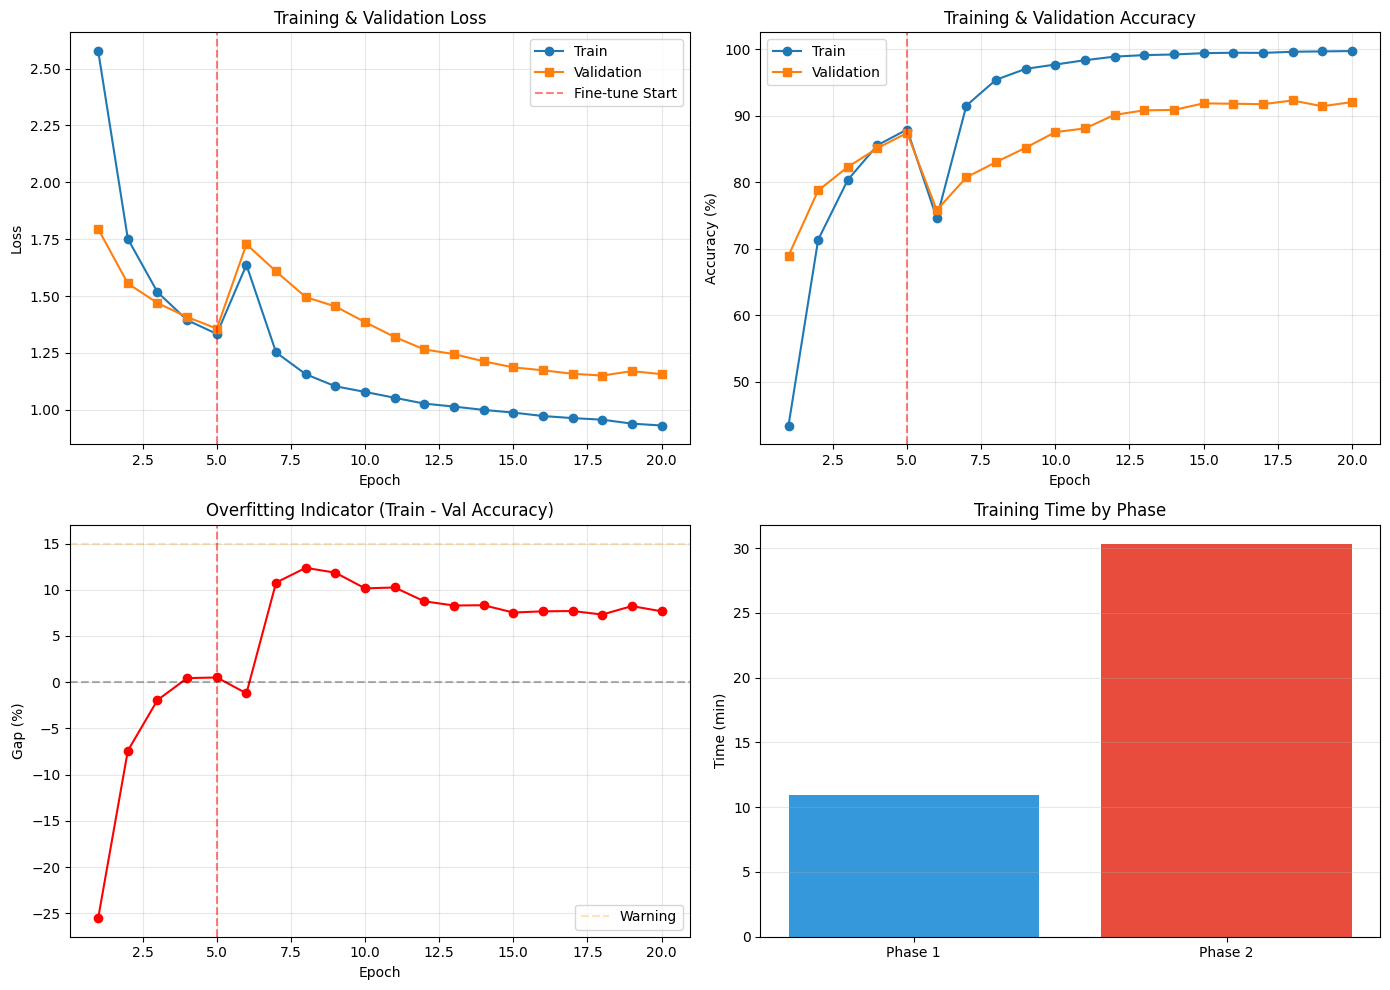


 Overfitting Analysis:
   Final gap: +7.67%
   Max gap: +12.37%
    Good generalization!


In [ ]:
print(" Plotting training history...")
acc_gaps = plot_training_history(history, CONFIG["phase1_epochs"], CONFIG["save_dir"], (phase1_time, phase2_time))


final_gap = acc_gaps[-1]
max_gap = max(acc_gaps)
print(f"\n Overfitting Analysis:")
print(f"   Final gap: {final_gap:+.2f}%")
print(f"   Max gap: {max_gap:+.2f}%")
if final_gap > 15:
    print("     Significant overfitting detected!")
elif final_gap > 8:
    print("    Moderate overfitting")
else:
    print("    Good generalization!")

**Test Set Evaluation**

In [ ]:
print("\n" + "="*60)
print(" TEST SET EVALUATION (27 Plant Disease Classes)")
print("="*60)

# Load best model
model = keras.models.load_model(checkpoint_path)

test_results = model.evaluate(test_generator, verbose=0)
print(f"\n Test Metrics:")
print(f"   Loss: {test_results[0]:.4f}")
print(f"   Accuracy: {test_results[1]*100:.2f}%")
print(f"   Top-3 Accuracy: {test_results[2]*100:.2f}%")


 TEST SET EVALUATION (27 Plant Disease Classes)



 Test Metrics:
   Loss: 1.1941
   Accuracy: 90.74%
   Top-3 Accuracy: 96.30%


In [ ]:
# Detailed predictions
test_generator.reset()
predictions = model.predict(test_generator, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Classification report
print(" Per-Class Performance:")
report = classification_report(
    true_classes, predicted_classes,
    target_names=list(test_generator.class_indices.keys()),
    digits=3, zero_division=0
)
print(report)

 Per-Class Performance:
                            precision    recall  f1-score   support

           Apple Scab Leaf      0.926     0.833     0.877        60
                Apple leaf      0.966     0.933     0.949        60
           Apple rust leaf      0.921     0.967     0.943        60
          Bell_pepper leaf      0.908     0.983     0.944        60
     Bell_pepper leaf spot      0.889     0.933     0.911        60
            Blueberry leaf      0.948     0.917     0.932        60
               Cherry leaf      0.923     1.000     0.960        60
       Corn Gray leaf spot      0.912     0.867     0.889        60
          Corn leaf blight      0.946     0.883     0.914        60
            Corn rust leaf      0.905     0.950     0.927        60
                Peach leaf      0.966     0.933     0.949        60
  Potato leaf early blight      0.957     0.733     0.830        60
   Potato leaf late blight      0.839     0.867     0.852        60
            Raspberry l

**Confusion Matrix**

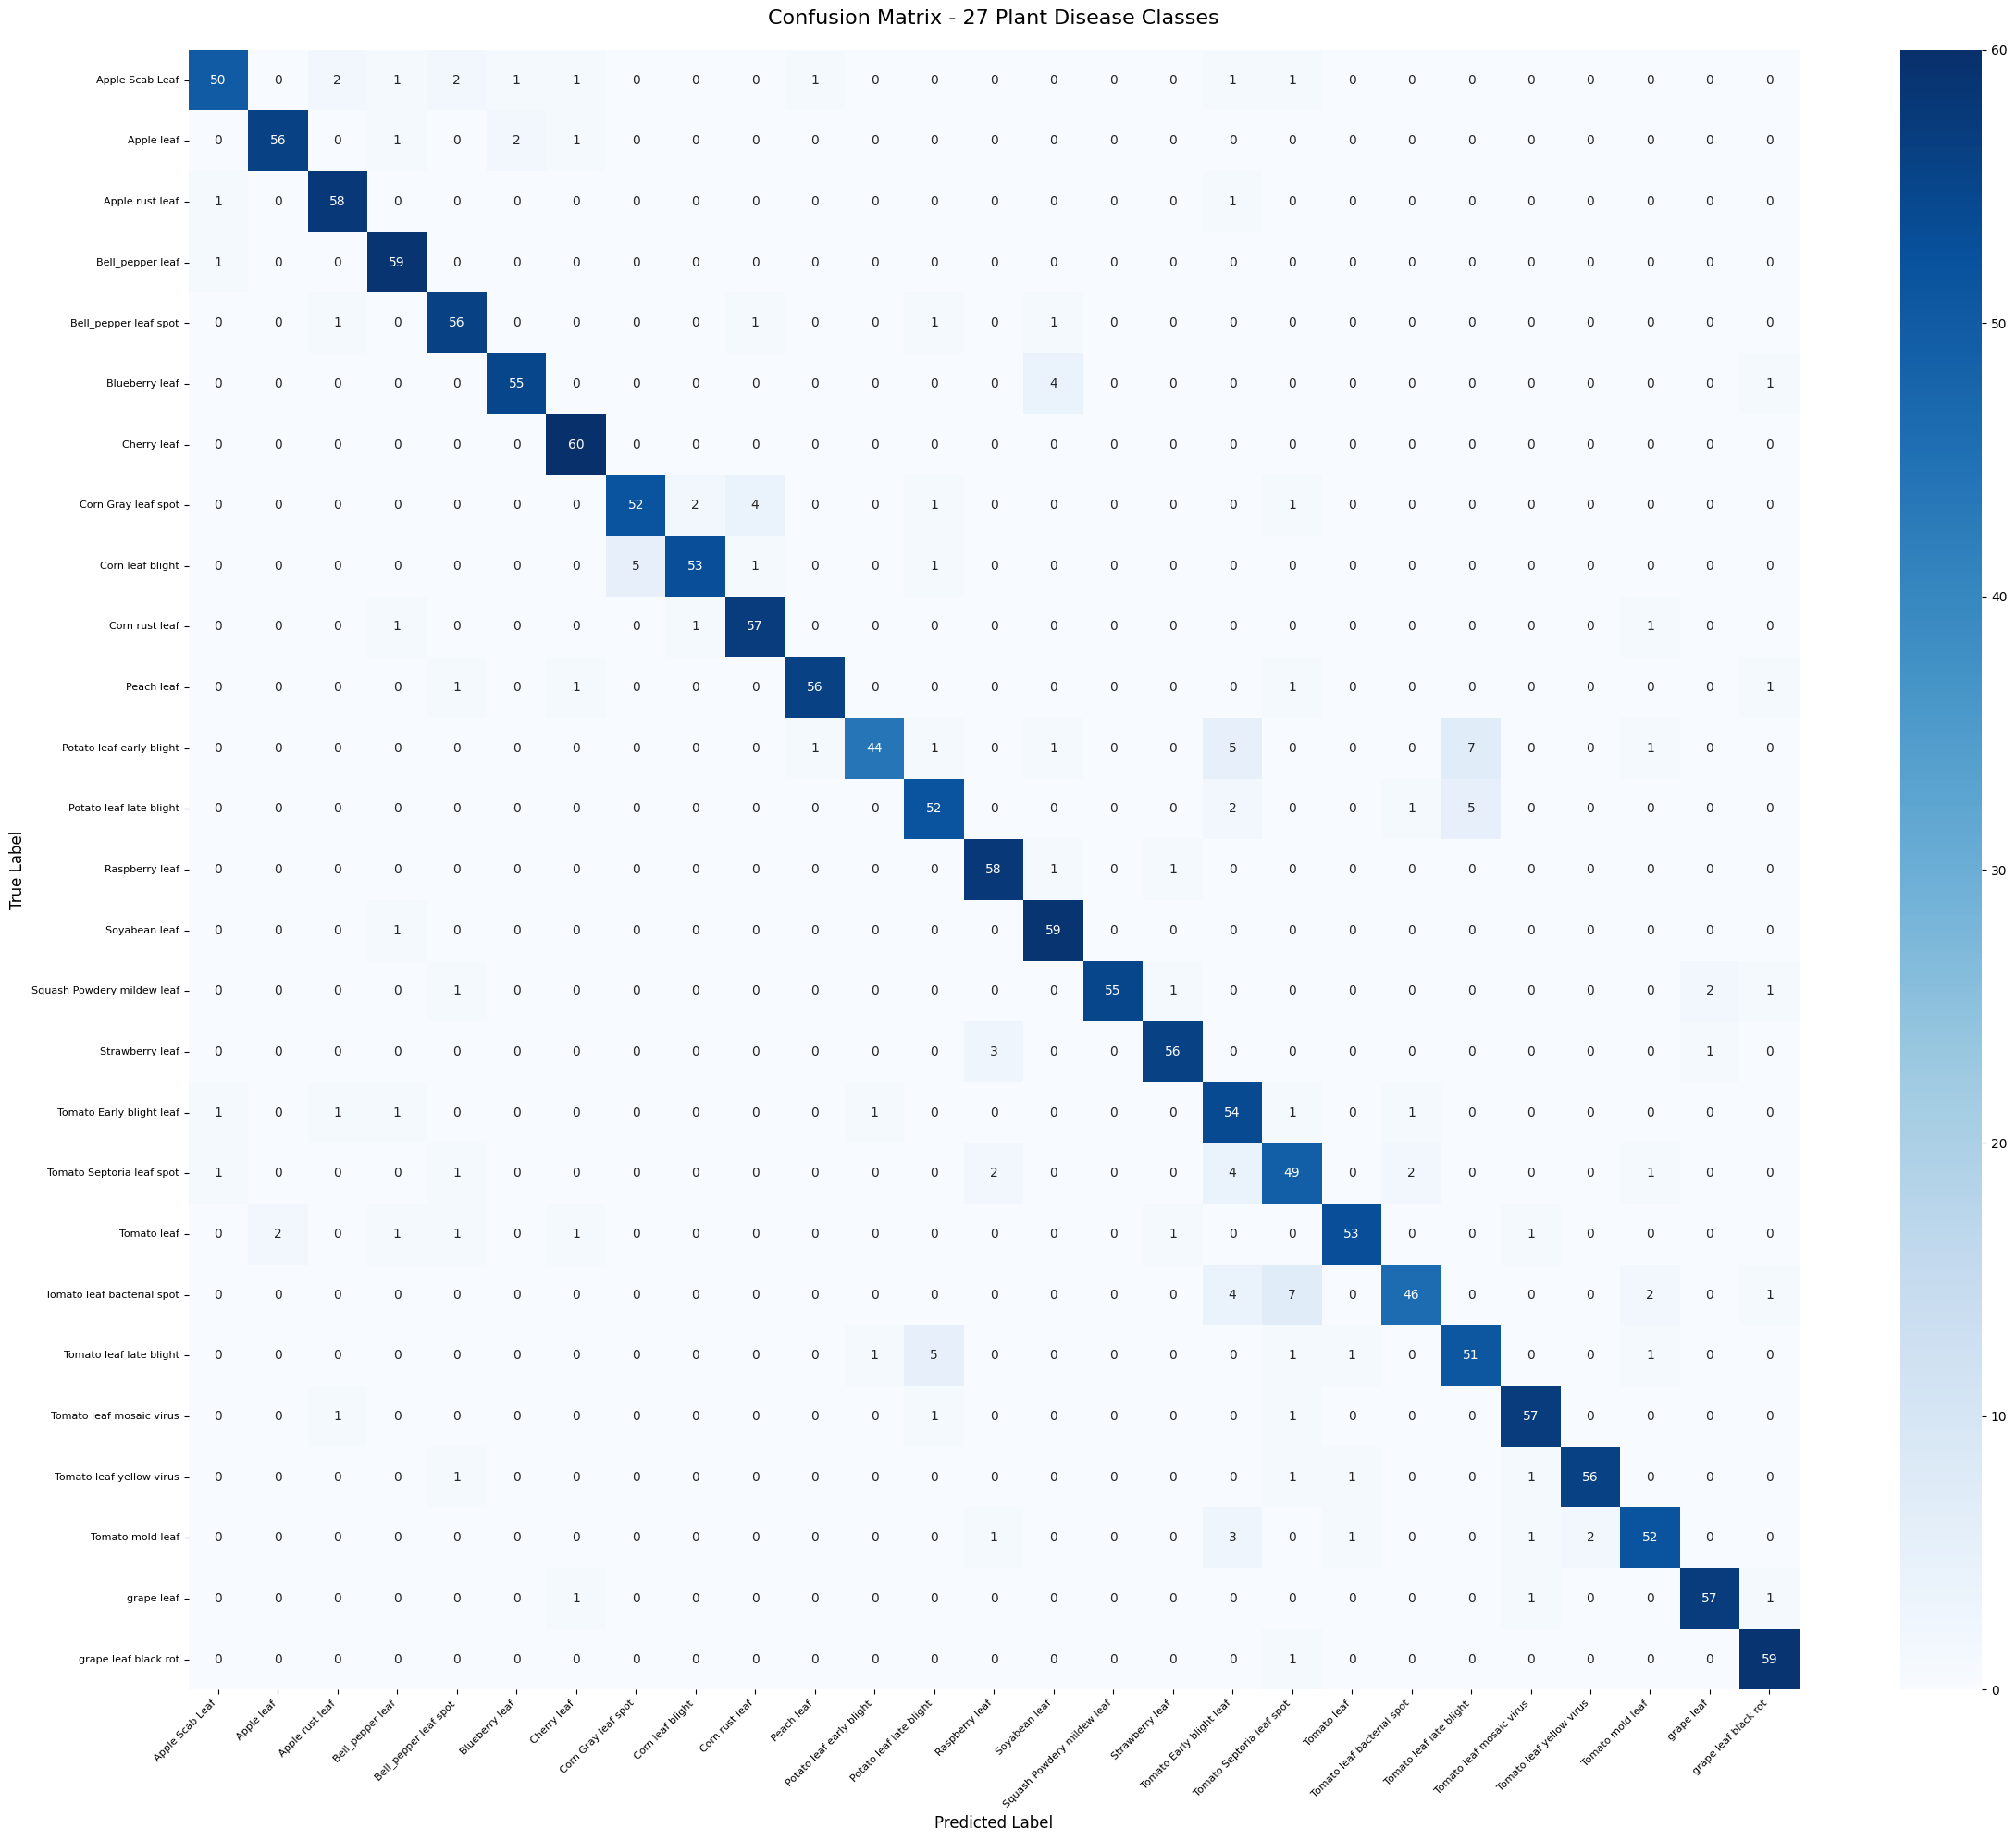

In [ ]:
# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(24, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.title('Confusion Matrix - 27 Plant Disease Classes', fontsize=16, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)


**Model Export**

In [ ]:
print("\n" + "="*60)
print(" EXPORTING MODEL")
print("="*60)

# Full model
model.save(str(CONFIG["save_dir"] / "plant_disease_classifier.h5"))
print("    Saved: plant_disease_classifier.h5")


 EXPORTING MODEL
    Saved: plant_disease_classifier.h5


In [ ]:
model.save("plant_disease_classifier.h5")


In [ ]:
from google.colab import files
files.download("plant_disease_classifier.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Class metadata
class_info = {
    "classes": DATASET_CONFIG["classes"],
    "class_indices": dict(test_generator.class_indices),
    "num_classes": num_classes,
    "img_size": IMG_SIZE,
    "dataset_info": {
        "samples_per_class": DATASET_CONFIG["target_per_class"],
        "train_per_class": DATASET_CONFIG["samples_per_split"]["train"],
        "val_per_class": DATASET_CONFIG["samples_per_split"]["val"],
        "test_per_class": DATASET_CONFIG["samples_per_split"]["test"],
        "total_samples": DATASET_CONFIG["total_samples"]
    }
}
with open(CONFIG["save_dir"] / "plant_disease_classes.json", 'w') as f:
    json.dump(class_info, f, indent=2)
print("    Saved: plant_disease_classes.json")

    Saved: plant_disease_classes.json


In [ ]:
from google.colab import files
files.download(str(json_path))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Training Summary**

In [ ]:
print("\n" + "="*60)
print(" TRAINING COMPLETE!")
print("="*60)
print("  Applied Techniques:")
print("   ✓ Transfer learning (MobileNetV2)")
print("   ✓ Two-phase training")
print("   ✓ Balanced pre-augmented dataset (400 samples/class)")
print("   ✓ Train/Val/Test split (280/60/60 per class)")
print("   ✓ No runtime augmentation (dataset pre-augmented)")
print("   ✓ Label smoothing")
print("   ✓ Dropout regularization (2 layers)")
print("   ✓ L2 regularization (weight decay)")
print("   ✓ Batch normalization")
print("   ✓ Early stopping")
print("   ✓ Learning rate scheduling")
print(f"\n Dataset Summary:")
print(f"   Total classes: {num_classes}")
print(f"   Train: {DATASET_CONFIG['total_train']:,} samples")
print(f"   Val: {DATASET_CONFIG['total_val']:,} samples")
print(f"   Test: {DATASET_CONFIG['total_test']:,} samples")
print(f"\n Final Test Accuracy: {test_results[1]*100:.2f}%")
print(f"\n All exports saved to: {CONFIG['save_dir']}")


 TRAINING COMPLETE!
  Applied Techniques:
   ✓ Transfer learning (MobileNetV2)
   ✓ Two-phase training
   ✓ Balanced pre-augmented dataset (400 samples/class)
   ✓ Train/Val/Test split (280/60/60 per class)
   ✓ No runtime augmentation (dataset pre-augmented)
   ✓ Label smoothing
   ✓ Dropout regularization (2 layers)
   ✓ L2 regularization (weight decay)
   ✓ Batch normalization
   ✓ Early stopping
   ✓ Learning rate scheduling

 Dataset Summary:
   Total classes: 27
   Train: 7,560 samples
   Val: 1,620 samples
   Test: 1,620 samples

 Final Test Accuracy: 90.74%

 All exports saved to: /kaggle/working/plant_disease_model_exports


In [ ]:
correct_json = {
    "classes": [cls for cls, idx in sorted(true_class_indices.items(), key=lambda x: x[1])],
    "class_indices": {cls: idx for cls, idx in sorted(true_class_indices.items(), key=lambda x: x[1])},
    "num_classes": len(true_class_indices),
    "img_size": 224
}

with open("plant_disease_classes_FIXED.json", "w") as f:
    json.dump(correct_json, f, indent=2)

print(" Saved: plant_disease_classes_FIXED.json")


 Saved: plant_disease_classes_FIXED.json


**Image Test**

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import json
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from PIL import Image


MODEL_PATH = "plant_disease_classifier.h5"
JSON_PATH = "plant_disease_classes_FIXED.json"
IMAGE_PATH = "/content/tomato_early_blight.jpg"
TARGET_SIZE = (224, 224)
TOP_K = 5


model = tf.keras.models.load_model(MODEL_PATH, compile=False)

with open(JSON_PATH, "r") as f:
    class_info = json.load(f)

class_names = class_info["classes"]



def preprocess_img(img_path, target_size=TARGET_SIZE):

    # Load and preprocess image to model input.

    img = Image.open(img_path).convert("RGB")
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0).astype("float32")
    img_array = preprocess_input(img_array)
    return img_array

def predict_top5(img_array):

    # Predict top-5 classes from a single preprocessed image.

    preds = model.predict(img_array)[0]
    preds = tf.nn.softmax(preds).numpy()
    top5_idx = preds.argsort()[-TOP_K:][::-1]
    return [(class_names[i], preds[i]*100) for i in top5_idx]

def predict_tta(img_path, target_size=TARGET_SIZE):

    # Test-Time Augmentation: original + horizontal flip.

    img = Image.open(img_path).convert("RGB")
    img1 = img.resize(target_size)
    img2 = img1.transpose(Image.FLIP_LEFT_RIGHT)

    batch = np.stack([np.array(img1), np.array(img2)], axis=0)
    batch = preprocess_input(batch.astype("float32"))

    preds = model.predict(batch)
    preds = tf.nn.softmax(preds, axis=-1).numpy()
    avg_preds = preds.mean(axis=0)
    top5_idx = avg_preds.argsort()[-TOP_K:][::-1]
    return [(class_names[i], avg_preds[i]*100) for i in top5_idx]

print("=== Regular Prediction ===")
img_array = preprocess_img(IMAGE_PATH)
top5 = predict_top5(img_array)
for rank, (cls, prob) in enumerate(top5, 1):
    print(f"{rank}. {cls} — {prob:.2f}%")

print("\n=== TTA Prediction (center crop + horizontal flip) ===")
top5_tta = predict_tta(IMAGE_PATH)
for rank, (cls, prob) in enumerate(top5_tta, 1):
    print(f"{rank}. {cls} — {prob:.2f}%")

# Show final predicted class
final_class, final_conf = top5_tta[0]  # take top-1 from TTA for best confidence
print("\n=== FINAL PREDICTION ===")
print(f"Predicted Class: {final_class}")
print(f"Confidence: {final_conf:.2f}%")


=== Regular Prediction ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1. Tomato Early blight leaf — 8.83%
2. Potato leaf early blight — 3.55%
3. Corn leaf blight — 3.54%
4. Tomato leaf late blight — 3.53%
5. Raspberry leaf — 3.51%

=== TTA Prediction (center crop + horizontal flip) ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1. Tomato Early blight leaf — 8.76%
2. Corn leaf blight — 3.56%
3. Tomato leaf late blight — 3.54%
4. Potato leaf early blight — 3.53%
5. Raspberry leaf — 3.52%

=== FINAL PREDICTION ===
Predicted Class: Tomato Early blight leaf
Confidence: 8.76%
